# Run level 2A, 2B and 3 pipelines on fullband MRS data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) Feb 25th 2019

This notebook demonstrates the execution of the level 2A, 2B, and 3 pipelines for MRS data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The files used in this notebook are from a fullband MIRISim simulation of a point source with power-law (alpha=1) plus emission lines spectrum. The simulated observation is a four-point dither on the source for all channels and bands. This requires three runs of MIRISim, one for each disperser.

The steps applied are:

- ramps to slopes pipeline (Detector1Pipeline)

- CALSPEC2 steps and spectral extraction from each dither (Spec2Pipeline)

- combination of dithers and spectral extraction (Spec3Pipeline)

- manual conversion of extracted spectra to Jy 


#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0500.pmap"

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input and output location

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'MRS_fullband'
input_dir = 'MRS_fullband_demo_data'
input_files = glob.glob(os.path.join(input_dir, '20*', 'det_images', '*.fits'))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFUSHORT	 1	 50	 FAST	 12	 SHORT



Filename: MRS_fullband_demo_data/20190222_161923_mirisim/det_images/det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     114   ()      
  1  SCI           1 ImageHDU        57   (1032, 1024, 50, 1)   float32   
  2  REFOUT        1 ImageHDU        15   (258, 1024, 50, 1)   float32   
  3  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   6322R x 1C   [B]   


### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [4]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)


    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.
    


#### run pipeline
We pass the level 1B files (demo data). We need to explicitly skip the IPC step. There is an issue currently affecting the pipelining of MIRISim data through the refpix which is being looked into. For now, we just skip this step.
The output level 2A files will be saved in the output_dir as '*_rate.fits'. Since we know the simulation is of a point source, we can set the source type metadata to 'POINT' at this stage as that information is used later in spectral extraction. Otherwise, the pipeline will set the default source type for MRS which is 'EXTENDED'


In [ ]:
for f in input_files:
    dm = datamodels.MIRIRampModel(f)
    dm.meta.target.source_type = 'POINT'
    Detector1Pipeline.call(dm, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True},
                                  'refpix': {'skip': True}})


2019-02-25 21:31:42,094 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-25 21:31:42,096 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-25 21:31:42,098 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-02-25 21:31:42,100 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-02-25 21:31:42,102 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-02-25 21:31:42,103 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-02-25 21:31:42,105 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-02-25 21:31:42,107 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-02-25 21:31:42,109 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-02-25 21:31:42,111 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-02-25 

2019-02-25 21:32:13,355 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-25 21:32:13,359 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2019-02-25 21:32:13,467 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-02-25 21:32:14,732 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-02-25 21:32:14,995 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-02-25 21:32:32,965 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2019-02-25 21:32:33,026 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-25 21:32:33,089 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE re

2019-02-25 21:35:06,478 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-25 21:35:06,479 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.
2019-02-25 21:35:06,480 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done
2019-02-25 21:35:06,519 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-25 21:35:07,612 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done
2019-02-25 21:35:07,666 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-25 21:35:08,678 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done
2019-02-25 21:35:08,733 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampMo

2019-02-25 21:38:09,380 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2019-02-25 21:38:09,381 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits'.
2019-02-25 21:38:09,382 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0022.fits'.
2019-02-25 21:38:09,383 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2019-02-25 21:38:09,383 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits'.
2019-02-25 21:38:09,384 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jw

2019-02-25 21:41:09,614 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-25 21:41:09,656 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2019-02-25 21:41:09,657 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2019-02-25 21:41:09,660 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2019-02-25 21:41:09,660 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2019-02-25 21:41:09,791 - stpipe.Detector1Pipeline - INFO - Saved model in MRS_fullband_demo_data_pipelined/det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits
2019-02-25 21:41:09,792 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2019-02-25 21:41:11,886 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-25 21:41:11,888 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep 

2019-02-25 21:41:36,541 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=50, nframes=1, groupgap=0
2019-02-25 21:41:36,542 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2019-02-25 21:41:38,090 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2019-02-25 21:41:38,201 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).
2019-02-25 21:41:38,202 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2019-02-25 21:41:38,203 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2019-02-25 21:41:38,257 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).
2019-02-25 21:41:38,271 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-25 21:41:38,275 - stp

2019-02-25 21:44:29,103 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0021.fits
2019-02-25 21:44:30,129 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2019-02-25 21:44:30,183 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).
2019-02-25 21:44:30,201 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0021.fits
2019-02-25 21:44:31,837 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done
2019-02-25 21:44:31,882 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).
2019-02-25 21:44:31,882 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.
2019-02-25 21:44:

2019-02-25 21:47:33,162 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<MIRIRampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).
2019-02-25 21:47:33,176 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2019-02-25 21:47:33,181 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0050.fits'.
2019-02-25 21:47:33,182 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0006.fits'.
2019-02-25 21:47:33,183 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_line

2019-02-25 21:48:07,614 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all final groups flagged as DO_NOT_USE.
2019-02-25 21:48:07,615 - stpipe.Detector1Pipeline.ramp_fit - INFO - Effective integration time per group: 2.77504
2019-02-25 21:48:10,144 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)

2019-02-25 21:48:10,224 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:1178: RuntimeWarning: invalid value encountered in less
  err_2d_array[err_2d_array < 0] = 0

2019-02-25 21:50:39,690 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:475: RuntimeWarning: divide by zero encounter

2019-02-25 21:50:48,231 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done
2019-02-25 21:50:48,283 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).
2019-02-25 21:50:48,301 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0026.fits
2019-02-25 21:50:49,833 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2019-02-25 21:50:49,886 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).
2019-02-25 21:50:49,936 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0008.fits
2019-02-25 21:50:50,939 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2019-02-25 21:50:50

2019-02-25 21:53:44,313 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0007.fits'.
2019-02-25 21:53:44,314 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0023.fits'.
2019-02-25 21:53:44,314 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2019-02-25 21:53:44,315 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2019-02-25 21:53:44,315 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2019-02-25 21:53:44,316 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2019-02-25 21:53:44,382 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-25 21:53:44,3

2019-02-25 21:57:02,814 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-25 21:57:02,815 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-02-25 21:57:02,817 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-02-25 21:57:02,819 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-02-25 21:57:02,820 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-02-25 21:57:02,822 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-02-25 21:57:02,824 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-02-25 21:57:02,826 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-02-25 21:57:02,828 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-02-25 21:57:02,829 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2019-

2019-02-25 21:57:31,447 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-25 21:57:31,451 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0006.fits
2019-02-25 21:57:31,527 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0038.fits
2019-02-25 21:57:32,658 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-02-25 21:57:32,922 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-02-25 21:57:50,753 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2019-02-25 21:57:50,809 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).
2019-02-25 21:57:50,862 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE refe

2019-02-25 22:00:22,798 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).
2019-02-25 22:00:22,798 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.
2019-02-25 22:00:22,800 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done
2019-02-25 22:00:22,838 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).
2019-02-25 22:00:23,847 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done
2019-02-25 22:00:23,899 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).
2019-02-25 22:00:24,900 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done
2019-02-25 22:00:24,951 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel

2019-02-25 22:03:37,302 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2019-02-25 22:03:37,303 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits'.
2019-02-25 22:03:37,304 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0022.fits'.
2019-02-25 22:03:37,305 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2019-02-25 22:03:37,305 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits'.
2019-02-25 22:03:37,306 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jw

2019-02-25 22:06:36,971 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2019-02-25 22:06:36,972 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2019-02-25 22:06:36,975 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2019-02-25 22:06:36,976 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2019-02-25 22:06:37,104 - stpipe.Detector1Pipeline - INFO - Saved model in MRS_fullband_demo_data_pipelined/det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits
2019-02-25 22:06:37,105 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2019-02-25 22:06:38,910 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-25 22:06:38,911 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-25 22:06:38,912 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-02-25 22:06:38,915 - stpipe.Detector1Pipeline.saturation - INFO - S

2019-02-25 22:06:52,566 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2019-02-25 22:06:54,152 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2019-02-25 22:06:54,270 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).
2019-02-25 22:06:54,271 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2019-02-25 22:06:54,273 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2019-02-25 22:06:54,326 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).
2019-02-25 22:06:54,340 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-25 22:06:54,345 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_

2019-02-25 22:09:44,713 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0021.fits
2019-02-25 22:09:45,757 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2019-02-25 22:09:45,809 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).
2019-02-25 22:09:45,827 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0021.fits
2019-02-25 22:09:47,482 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done
2019-02-25 22:09:47,528 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).
2019-02-25 22:09:47,529 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.
2019-02-25 22:09:47

2019-02-25 22:13:01,790 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<MIRIRampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).
2019-02-25 22:13:01,803 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2019-02-25 22:13:01,809 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0050.fits'.
2019-02-25 22:13:01,811 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0006.fits'.
2019-02-25 22:13:01,811 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linear

2019-02-25 22:13:37,160 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all final groups flagged as DO_NOT_USE.
2019-02-25 22:13:37,161 - stpipe.Detector1Pipeline.ramp_fit - INFO - Effective integration time per group: 2.77504
2019-02-25 22:16:07,382 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 50
2019-02-25 22:16:07,383 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1
2019-02-25 22:16:07,482 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2019-02-25 22:16:07,577 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).
2019-02-25 22:16:07,617 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2019-02-25 22:16:07,617 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2019-02-25 22:16:07,620 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_

2019-02-25 22:16:17,912 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2019-02-25 22:16:17,965 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).
2019-02-25 22:16:17,983 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0056.fits
2019-02-25 22:16:34,606 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=50, nframes=1, groupgap=0
2019-02-25 22:16:34,606 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2019-02-25 22:16:36,106 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2019-02-25 22:16:36,214 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).
2019-02-25 22:16

2019-02-25 22:19:23,970 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES={} is a power of 2; correction not needed
2019-02-25 22:19:23,971 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2019-02-25 22:19:23,973 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2019-02-25 22:19:24,029 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).
2019-02-25 22:19:24,046 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0021.fits
2019-02-25 22:19:25,237 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2019-02-25 22:19:25,288 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).
2019-02-25 22:19:25,305 - stpipe.Detector1Pipeline.saturation 

2019-02-25 22:22:42,550 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2019-02-25 22:22:42,552 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2019-02-25 22:22:42,553 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2019-02-25 22:22:42,555 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2019-02-25 22:22:42,556 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2019-02-25 22:22:42,636 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<MIRIRampModel(1, 50, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).
2019-02-25 22:22:42,651 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2019-02-25 22:22:42,657

2019-02-25 22:23:18,587 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0006.fits
2019-02-25 22:23:18,610 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2019-02-25 22:23:18,611 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2019-02-25 22:23:18,614 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all first groups flagged as DO_NOT_USE.
2019-02-25 22:23:18,616 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all final groups flagged as DO_NOT_USE.
2019-02-25 22:23:18,617 - stpipe.Detector1Pipeline.ramp_fit - INFO - Effective integration time per group: 2.77504
2019-02-25 22:25:46,923 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 50
2019-02-25 22:25:46,923 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1
2019-02-25 22:25:47,021 - stpipe.Detector1Pipeline.ramp_fit - INFO - 

2019-02-25 22:25:55,094 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits
2019-02-25 22:25:56,703 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2019-02-25 22:25:56,753 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).
2019-02-25 22:25:56,801 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0007.fits
2019-02-25 22:25:57,863 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2019-02-25 22:25:57,924 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).
2019-02-25 22:25:57,942 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file 

2019-02-25 22:29:02,866 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2019-02-25 22:29:02,866 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2019-02-25 22:29:02,867 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2019-02-25 22:29:02,867 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2019-02-25 22:29:02,935 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).
2019-02-25 22:29:02,949 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES={} is a power of 2; correction not needed
2019-02-25 22:29:02,950 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2019-02-25 22:29:02,951 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2019-02-25 22:29:03,016 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init run

2019-02-25 23:10:26,280 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-02-25 23:10:26,284 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-02-25 23:10:26,288 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-02-25 23:10:26,293 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-02-25 23:10:26,297 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-02-25 23:10:26,300 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-02-25 23:10:26,304 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2019-02-25 23:10:26,308 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2019-02-25 23:10:26,313 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2019-02-25 23:10:26,317 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2019-0

2019-02-25 23:11:21,865 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-02-25 23:11:24,866 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-02-25 23:11:25,659 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-02-25 23:12:12,435 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2019-02-25 23:12:12,552 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).
2019-02-25 23:12:12,681 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-02-25 23:12:12,754 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_000

2019-02-25 23:19:05,331 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done
2019-02-25 23:19:05,453 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).
2019-02-25 23:19:08,770 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done
2019-02-25 23:19:08,914 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).
2019-02-25 23:19:12,535 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done
2019-02-25 23:19:12,689 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).
2019-02-25 23:19:12,758 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_lineari

2019-02-25 23:27:17,629 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0021.fits'.
2019-02-25 23:27:17,632 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2019-02-25 23:27:17,634 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0038.fits'.
2019-02-25 23:27:17,636 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0008.fits'.
2019-02-25 23:27:17,638 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0021.fits'.
2019-02-25 23:27:17,641 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2019-02-25 23:27:17,643 - stpipe.Detector1Pip

2019-02-25 23:35:49,879 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2019-02-25 23:35:49,881 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2019-02-25 23:35:50,289 - stpipe.Detector1Pipeline - INFO - Saved model in MRS_fullband_demo_data_pipelined/det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits
2019-02-25 23:35:50,291 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2019-02-25 23:35:54,864 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-25 23:35:54,868 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-25 23:35:54,872 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-02-25 23:35:54,876 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-02-25 23:35:54,880 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-02-25 23:35:54,884 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasSte

2019-02-25 23:36:50,024 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).
2019-02-25 23:36:50,025 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2019-02-25 23:36:50,029 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2019-02-25 23:36:50,129 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).
2019-02-25 23:36:50,168 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-25 23:36:50,180 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2019-02-25 23:36:50,337 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-02-25 23:36:53,3

2019-02-25 23:44:28,838 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2019-02-25 23:44:28,956 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).
2019-02-25 23:44:29,022 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0021.fits
2019-02-25 23:44:34,055 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done
2019-02-25 23:44:34,169 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 50, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).
2019-02-25 23:44:34,171 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.
2019-02-25 23:44:34,175 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done
2019-02-25 23:44:34,286 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampM

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [ ]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('firstframe: %s' % dm.meta.cal_step.firstframe)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: None
linearity: COMPLETE
rscd: COMPLETE
firstframe: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: None
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [ ]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. 

Note that since MIRISim does not add straylight, we can skip the straylight correction step.

In [ ]:
for f in level2A_files:
    Spec2Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir, 
                       steps={'straylight':{'skip':True}})


2019-02-25 23:53:21,016 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2019-02-25 23:53:21,021 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-02-25 23:53:21,027 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-02-25 23:53:21,033 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2019-02-25 23:53:21,039 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2019-02-25 23:53:21,045 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2019-02-25 23:53:21,051 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-02-25 23:53:21,056 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2019-02-25 23:53:21,062 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2019-02-25 23:53:21,069 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2019-02-25 23:53:2

2019-02-25 23:53:39,858 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.001007525 -0.001270547 0.001840311 -0.001270547 0.001840311 0.001056231 -0.001007525 0.001056231
2019-02-25 23:53:39,859 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-02-25 23:53:39,884 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-02-25 23:53:40,068 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).
2019-02-25 23:53:40,315 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-25 23:53:41,621 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2019-02-25 23:53:41,792 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).
2019-02-25 2

2019-02-26 00:04:50,908 - stpipe.Spec2Pipeline - INFO - Finished processing product MRS_fullband_demo_data_pipelined/det_image_seq2_MIRIFULONG_34SHORTexp1
2019-02-26 00:04:50,909 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2019-02-26 00:04:52,928 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_fullband_demo_data_pipelined/det_image_seq2_MIRIFULONG_34SHORTexp1_cal.fits
2019-02-26 00:04:52,929 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2019-02-26 00:04:52,958 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2019-02-26 00:04:52,961 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-02-26 00:04:52,964 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-02-26 00:04:52,968 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2019-02-26 00:04:52,971 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2019-02-26 00:04:52,975 - stpipe.Spec2Pipe

2019-02-26 00:05:17,456 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/gwcs/selector.py:444: RuntimeWarning: invalid value encountered in less_equal
  temp = np.where(np.logical_or(temp <= val_range[0],

2019-02-26 00:05:17,461 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/gwcs/selector.py:445: RuntimeWarning: invalid value encountered in greater_equal
  temp >= val_range[1]),

2019-02-26 00:05:18,269 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.001033813 -0.000952200 0.000449696 -0.000952200 0.000449696 0.000486515 -0.001033813 0.000486515
2019-02-26 00:05:18,271 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-02-26 00:05:18,294 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-02-26 00:05:18,520 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from de

### check of output

The level 2B pipeline for the MRS produces three files for each input:

_cal.fits - the calibrated level 2B file from each dither

_s3d.fits - the cube from each dither

_x1d.fits - the 1d spectrum from each dither


In [10]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
cube_files = glob.glob(os.path.join(output_dir,'*_s3d.fits'))

#### level 2B file

In [11]:
with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('straylight: %s' % dm.meta.cal_step.straylight)
    print('fringe: %s' % dm.meta.cal_step.fringe)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
straylight: None
fringe: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

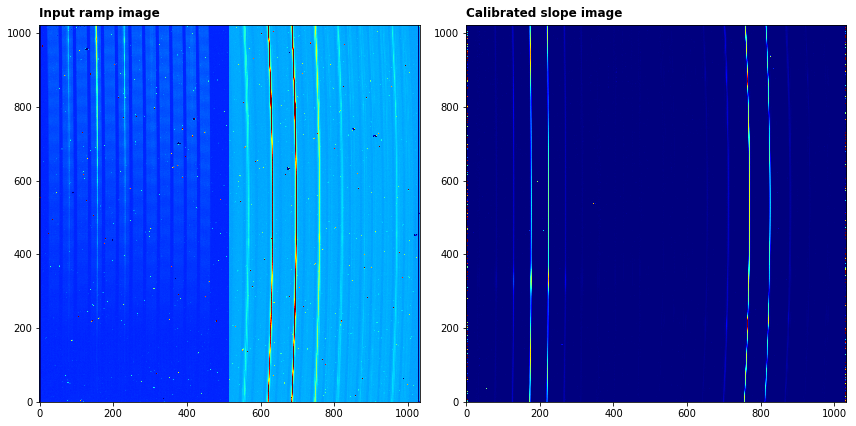

In [12]:
# open the input image as a jwst data model
with datamodels.MIRIRampModel(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0, vmax=500)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

#### Look at cube file. We'll look at the first dither only

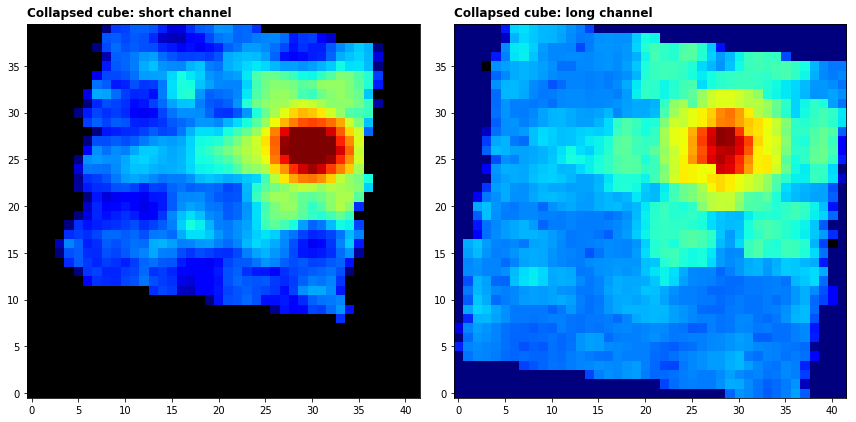

In [59]:
# open the cube as a jwst data model
with datamodels.open(cube_files[0]) as cube_dm:
    
    # plot--------------------------------------
    # sum some of the the frames in each channel
    # Note the user may have to adjust the scaling
    # parameters
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=1e4))
    axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(np.sum(cube_dm.data[4000:4300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=1e5))
    axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

### Level 3 pipeline

The Spec3Pipeline is not quite working in jwst-0.9.2. The main issue is with output file writing.

For now, we just use use the steps individually. The steps are mrs_imatch, outlier_detection, cube_build and extract_1d. Since mrs_imatch and outlier_detection are still in development, we only use cube_build and extract_1d.

We first create an association file in the output directory containing the list of level 2B files ("_cal.fits") produced by the level 2B pipeline. 

#### create the level 3 association using the asn_from_list tool

In [14]:
call(["asn_from_list", "-o", "MRS_asn.json"] + level2B_files + ["--product-name", "dither"])


0

In [31]:
from jwst.extract_1d import extract_1d_step
from jwst.cube_build import cube_build_step

dms = datamodels.open("MRS_asn.json")
cube_dms = cube_build_step.CubeBuildStep.call(dms, save_results=True, output_dir=output_dir)
spec_dms = extract_1d_step.Extract1dStep.call(cube_dms, output_use_model=True, save_results=True, 
                                              output_dir=output_dir)


2018-04-11 08:00:48,501 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2018-04-11 08:00:54,920 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args (<jwst.datamodels.container.ModelContainer object at 0x1813e839b0>,).
2018-04-11 08:00:54,921 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2018-04-11 08:00:54,922 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2018-04-11 08:00:54,922 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2018-04-11 08:00:54,923 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2018-04-11 08:00:54,926 - stpipe.CubeBuildStep - INFO - Power Weighting distance : 2.000000
2018-04-11 08:04:31,773 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI Channels: ['1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '4']
2018-04-11 08:04:31,774 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI subchannels: ['SHORT', 'MEDIUM', 'LONG', 'SHORT

2018-04-11 08:13:58,111 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 2 MEDIUM 
2018-04-11 08:13:58,112 - stpipe.CubeBuildStep - INFO - Output Name MRS_fullband_pipelined/dither_ch2-medium_s3d.fits
2018-04-11 08:16:21,137 - stpipe.CubeBuildStep - INFO - Time Map All slices on Detector to Cube = 137.2.s
2018-04-11 08:16:22,553 - stpipe.CubeBuildStep - INFO - Time to interpolate at spaxel values = 1.4.s
2018-04-11 08:16:22,554 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux= 1.4.s
2018-04-11 08:16:25,503 - stpipe.CubeBuildStep - INFO - Region of interest  0.150000 0.002000
2018-04-11 08:16:25,504 - stpipe.CubeBuildStep - INFO - Number of bands in cube  1
2018-04-11 08:16:30,124 - stpipe.CubeBuildStep - INFO - Ra average 0.00002412.8
2018-04-11 08:16:30,128 - stpipe.CubeBuildStep - INFO - Cube Geometry:
2018-04-11 08:16:30,128 - stpipe.CubeBuildStep - INFO - axis# Naxis  CRPIX    CRVAL      CDELT(arc sec)  MIN & Max (xi,eta arc sec)
2018-04-11 08:16:30,129 - stpi

2018-04-11 08:30:57,588 - stpipe.CubeBuildStep - INFO - Output Name MRS_fullband_pipelined/dither_ch4-medium_s3d.fits
2018-04-11 08:33:36,274 - stpipe.CubeBuildStep - INFO - Time Map All slices on Detector to Cube = 158.1.s
2018-04-11 08:33:37,001 - stpipe.CubeBuildStep - INFO - Time to interpolate at spaxel values = 0.7.s
2018-04-11 08:33:37,002 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux= 0.7.s
2018-04-11 08:33:39,595 - stpipe.CubeBuildStep - INFO - Region of interest  0.400000 0.006000
2018-04-11 08:33:39,597 - stpipe.CubeBuildStep - INFO - Number of bands in cube  1
2018-04-11 08:33:45,020 - stpipe.CubeBuildStep - INFO - Ra average 0.00012812.8
2018-04-11 08:33:45,023 - stpipe.CubeBuildStep - INFO - Cube Geometry:
2018-04-11 08:33:45,025 - stpipe.CubeBuildStep - INFO - axis# Naxis  CRPIX    CRVAL      CDELT(arc sec)  MIN & Max (xi,eta arc sec)
2018-04-11 08:33:45,026 - stpipe.CubeBuildStep - INFO - Axis 1    36  19.00   0.00012822   0.34999999  -6.47499989   6.47499989
2

2018-04-11 08:38:06,308 - stpipe.Extract1dStep - INFO - Saved model in MRS_fullband_pipelined/dither_ch1-long_cubebuildstep_extract1dstep.fits
2018-04-11 08:38:06,879 - stpipe.Extract1dStep - INFO - Saved model in MRS_fullband_pipelined/dither_ch2-short_cubebuildstep_extract1dstep.fits
2018-04-11 08:38:07,456 - stpipe.Extract1dStep - INFO - Saved model in MRS_fullband_pipelined/dither_ch2-medium_cubebuildstep_extract1dstep.fits
2018-04-11 08:38:08,057 - stpipe.Extract1dStep - INFO - Saved model in MRS_fullband_pipelined/dither_ch2-long_cubebuildstep_extract1dstep.fits
2018-04-11 08:38:08,637 - stpipe.Extract1dStep - INFO - Saved model in MRS_fullband_pipelined/dither_ch3-short_cubebuildstep_extract1dstep.fits
2018-04-11 08:38:09,228 - stpipe.Extract1dStep - INFO - Saved model in MRS_fullband_pipelined/dither_ch3-medium_cubebuildstep_extract1dstep.fits
2018-04-11 08:38:09,847 - stpipe.Extract1dStep - INFO - Saved model in MRS_fullband_pipelined/dither_ch3-long_cubebuildstep_extract1dste

### plot the cubes from individual channels/bands
Note that known MIRISim issues such as the flux issues in channel 4 and the striping at the sides of the slices are apparent in these plots.

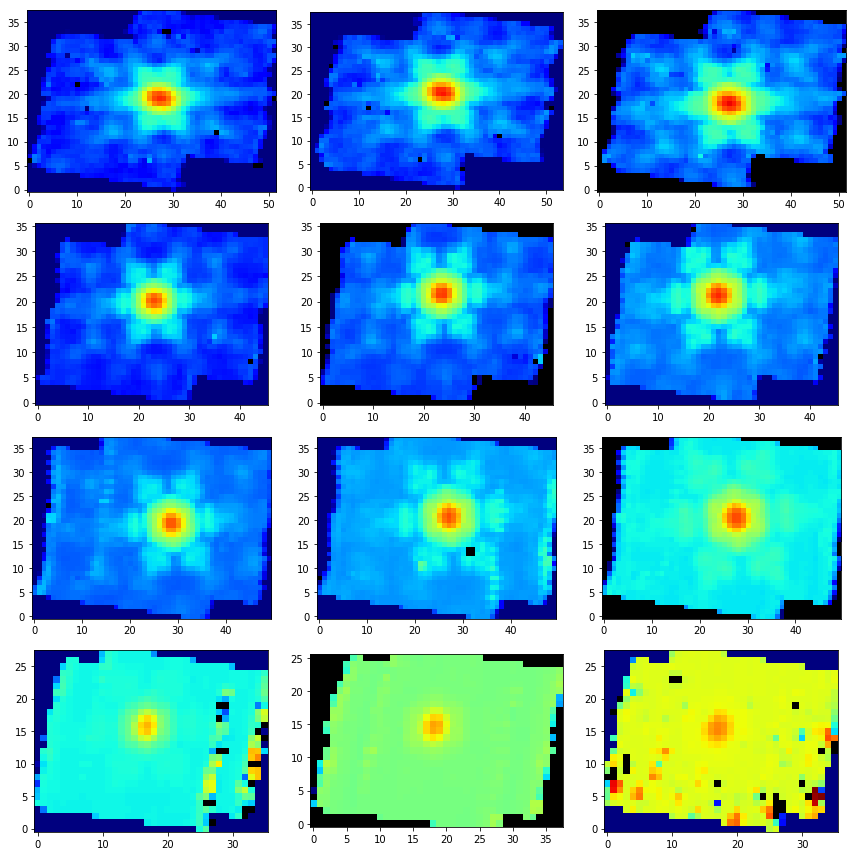

In [49]:
fig, axs = plt.subplots(4, 3, figsize=(12, 12))
axs = axs.ravel()

for n, cdm in enumerate(cube_dms):
    axs[n].imshow(np.sum(cdm.data[100:-100], axis=0), cmap='jet', interpolation='nearest', 
                  origin='lower', norm=LogNorm(vmin=20,vmax=1e6))
    axs[n].set_facecolor('black')
    
plt.tight_layout()
plt.show()



Since we have set the source type to 'POINT' above, the extract_1d step will use an aperture extraction and subtract a background with default values. The aperture centre is at pixel x/2, y/2, the radius is y/4, and the background annulus is from the radius to the radius*sqrt(2). In the future, more advanced extraction methods are planned. One can set also the aperture properties using a custom aperture reference file. Please contact pkavanagh@cp.dias.ie if you want to do this.

The extracted spectra are in units of mJy/arcsec^2. To convert these to mJy we multiply by the spaxel area. Note that an additional aperture correction factor for the encircled energy in the aperture should also be applied but we forego this here since the CDPs are currently not available.

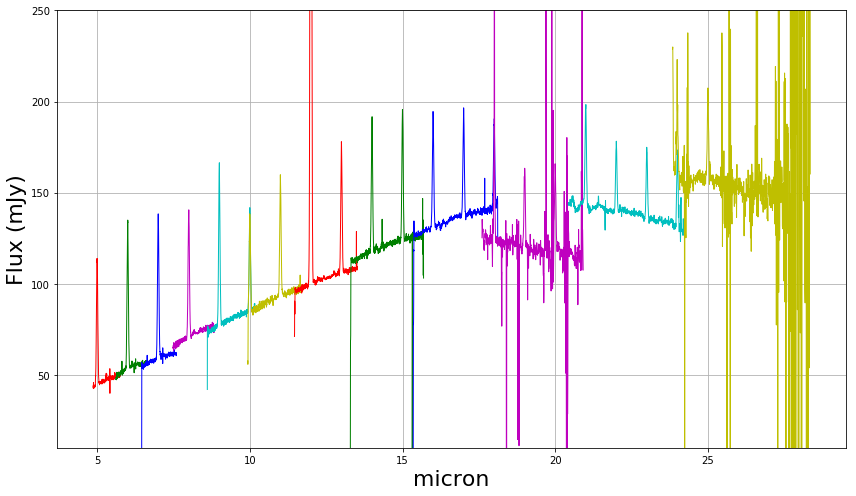

In [60]:
from cycler import cycler

fig, axs = plt.subplots(1, 1, figsize=(12, 7))
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'm', 'c', 'y'])))

for n, sdm in enumerate(spec_dms):
    spaxel_area = cube_dms[n].meta.wcsinfo.cdelt1 * cube_dms[n].meta.wcsinfo.cdelt2 * 3600 ** 2
    axs.plot(sdm.spec[0].spec_table['WAVELENGTH'][20:-20],
                sdm.spec[0].spec_table['FLUX'][20:-20] * spaxel_area, marker='.', markersize=0,
                linestyle='-', linewidth=1)

axs.set_ylabel(r'Flux (mJy)', fontsize=22)
axs.set_ylim(10, 250)
axs.set_xlabel('micron', fontsize=22)
axs.grid()

plt.tight_layout()
plt.show()

Our spectrum looks quite good up to channel 4. Both the known issues in MIRISim and the missing aperture correction factors should account for the shape of the spectrum in this channel.

### full band

In [61]:
from jwst.extract_1d import extract_1d_step
from jwst.cube_build import cube_build_step

dms = datamodels.open("MRS_asn.json")
cube_dms_full = cube_build_step.CubeBuildStep.call(dms, save_results=True, output_dir=output_dir, output_type='multi')
spec_dms_full = extract_1d_step.Extract1dStep.call(cube_dms_full, output_use_model=True, save_results=True, 
                                              output_dir=output_dir)


2018-04-12 10:57:28,052 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2018-04-12 10:57:47,690 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args (<jwst.datamodels.container.ModelContainer object at 0x195e2e97f0>,).
2018-04-12 10:57:47,690 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2018-04-12 10:57:47,691 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2018-04-12 10:57:47,692 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2018-04-12 10:57:47,693 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2018-04-12 10:57:47,694 - stpipe.CubeBuildStep - INFO - Power Weighting distance : 2.000000
2018-04-12 11:01:10,364 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI Channels: ['1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '4']
2018-04-12 11:01:10,365 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI subchannels: ['SHORT', 'MEDIUM', 'LONG', 'SHORT

### plot the cubes from individual channels/bands
Note that known MIRISim issues such as the flux issues in channel 4 and the striping at the sides of the slices are apparent in these plots.

1
(23619, 72, 98)


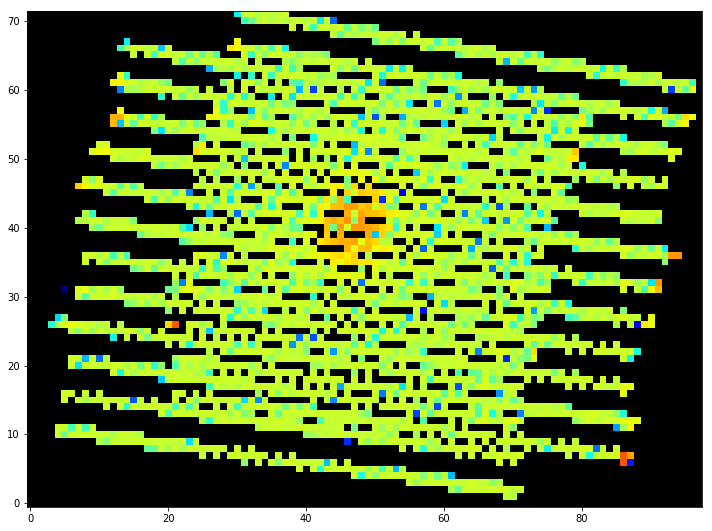

In [68]:
print(len(cube_dms_full))
print(cube_dms_full[0].data.shape)

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

axs.imshow(np.sum(cube_dms_full[0].data[21000:22000], axis=0), cmap='jet', interpolation='nearest', 
              origin='lower', norm=LogNorm(vmin=20,vmax=1e6))
axs.set_facecolor('black')
    
plt.tight_layout()
plt.show()



Since we have set the source type to 'POINT' above, the extract_1d step will use an aperture extraction and subtract a background with default values. The aperture centre is at pixel x/2, y/2, the radius is y/4, and the background annulus is from the radius to the radius*sqrt(2). In the future, more advanced extraction methods are planned. One can set also the aperture properties using a custom aperture reference file. Please contact pkavanagh@cp.dias.ie if you want to do this.

The extracted spectra are in units of mJy/arcsec^2. To convert these to mJy we multiply by the spaxel area. Note that an additional aperture correction factor for the encircled energy in the aperture should also be applied but we forego this here since the CDPs are currently not available.

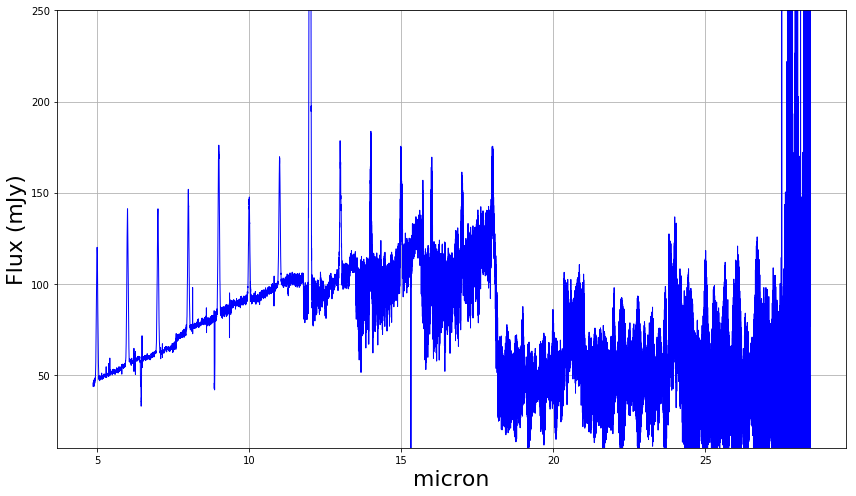

In [71]:
fig, axs = plt.subplots(1, 1, figsize=(12, 7))

spaxel_area = cube_dms_full[0].meta.wcsinfo.cdelt1 * cube_dms_full[0].meta.wcsinfo.cdelt2 * 3600 ** 2
axs.plot(spec_dms_full.spec[0].spec_table['WAVELENGTH'][20:-20],
            spec_dms_full.spec[0].spec_table['FLUX'][20:-20] * spaxel_area, marker='.', markersize=0,
            linestyle='-', linewidth=1, c='b')

axs.set_ylabel(r'Flux (mJy)', fontsize=22)
axs.set_ylim(10, 250)
axs.set_xlabel('micron', fontsize=22)
axs.grid()

plt.tight_layout()
plt.show()